In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import Dense, Activation, MaxPool1D,MaxPool2D,Conv1D, Conv2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from keras import applications
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
import cv2
%matplotlib inline

Using TensorFlow backend.


In [2]:
EXTRACT_FEATURES = False
FEATURE_FILE_NAME = "inception_features.npy"
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [3]:
def load(fname,test=False, cols=None):
    df = pd.read_csv(fname)
    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:
        df = df[list(cols)+['Image']]
    
    #print( df.count())
    df = df.dropna()
    columns = df.columns
    
    X = np.vstack(df['Image'].values)#/255
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns[:-1]].values
        #y = (y-48)/48
        X, y = shuffle(X, y, random_state=20)
        y = y.astype(np.float32)
    else:
        y = None
        columns = None
    
    return X, y, columns

def load2d(fname,test=False, cols=None):
    
    X, y, columns = load(fname,test, cols)
    X = X.reshape(-1,96,96, 1)
    
    return X, y, columns

def array_to_img(x):
#     rgbimg = cv2.resize(cv2.cvtColor(x,cv2.COLOR_GRAY2RGB),(224,224))
    rgbimg = cv2.cvtColor(x,cv2.COLOR_GRAY2RGB)
    rgbimg = rgbimg[...,::-1].astype(np.float32)
    a = np.expand_dims(rgbimg, axis=0)
    a = preprocess_input(a)
    return a

In [4]:
X, y, columns = load2d("data/training.csv",test=False)
columns = np.array(list(columns[:-1]))
columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [5]:
# mimg = X[0]
# rgbimg = cv2.resize(cv2.cvtColor(mimg,cv2.COLOR_GRAY2RGB),(224,224))
# cv2.imwrite("rgb.jpg",rgbimg)
# rgbimg = rgbimg[...,::-1].astype(np.float32)

# rgbimg.shape
# a = np.expand_dims(rgbimg, axis=0)
# print(a.shape)

# a = preprocess_input(a)
# # plt.imshow(rgbimg)

In [6]:
inception_model = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', pooling='avg')

In [7]:
# img = image.load_img("rgb.jpg", target_size=(224, 224))
# # print(img.shape)
# # convert image to numpy array
# x = image.img_to_array(img)
# print(x.shape)
# # the image is now in an array of shape (3, 224, 224) 
# # need to expand it to (1, 3, 224, 224) as it's expecting a list
# x = np.expand_dims(x, axis=0)
# print(x.shape)

# x = preprocess_input(x)
# print(x.shape)


# # print(x)
# # extract the features
# features = inception_model.predict(x)
# # convert from Numpy to a list of values
# features_arr = np.char.mod('%f', features)
# print(features_arr.shape)
# print(features.shape)
# print(np.squeeze(features))


In [8]:
inception_features = []
inception_features_array = np.zeros([X_train.shape[0],2048])

if EXTRACT_FEATURES:
    for i in range(X_train.shape[0]):
        if(i%10 == 0):
            print('.',end='')
        img = array_to_img(X_train[i])
        features = inception_model.predict(img)
#         print(features.shape)
        inception_features_array[i] = features.flatten()
    file = open(FEATURE_FILE_NAME,"wb")
#     inception_features_array = np.array(inception_features)
    np.save(file,inception_features_array)
else:
    file = open(FEATURE_FILE_NAME,'rb')
    inception_features_array = np.load(file)

In [9]:
# inception_features_array.shape
# (inception_features_array.reshape(inception_features_array.shape[0],-1))[6]

In [10]:
# inception_features_array = (inception_features_array.reshape(inception_features_array.shape[0],-1))

In [11]:
model = Sequential()
model.add(BatchNormalization())
model.add(Conv1D(128,3))
model.add(Activation("relu"))
model.add(MaxPool1D(pool_size=2,strides=2))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(30))
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
# model.summary()

In [12]:
inception_features_array  = np.expand_dims(inception_features_array, axis=2)
print(inception_features_array.shape)

(1819, 2048, 1)


In [13]:
# save best weights
checkpointer = ModelCheckpoint(filepath='face_model_in_cnn_ds_no_dropout.h5', verbose=1, save_best_only=True)

# num epochs
epochs = 50


# X_train, X_test, y_train, y_test = train_test_split(inception_features_array, y, test_size=0.15, random_state=42)
# run model
# inception_features_array = inception_features_array.reshape(inception_features_array.shape[0],32,64)
hist = model.fit(inception_features_array,y_train, epochs=epochs, 
                 validation_split=0.15, callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open("face_model_in_cnn_ds_no_dropout.json", "w") as json_file:
    json_file.write(model_json)

Train on 1546 samples, validate on 273 samples
Epoch 1/50
 - 18s - loss: 141.4473 - acc: 0.6630 - val_loss: 80.6466 - val_acc: 0.7033

Epoch 00001: val_loss improved from inf to 80.64660, saving model to face_model_in_cnn_ds_no_dropout.h5
Epoch 2/50
 - 15s - loss: 29.5076 - acc: 0.7005 - val_loss: 71.4024 - val_acc: 0.7033

Epoch 00002: val_loss improved from 80.64660 to 71.40239, saving model to face_model_in_cnn_ds_no_dropout.h5
Epoch 3/50
 - 15s - loss: 27.9549 - acc: 0.7089 - val_loss: 41.5030 - val_acc: 0.7033

Epoch 00003: val_loss improved from 71.40239 to 41.50298, saving model to face_model_in_cnn_ds_no_dropout.h5
Epoch 4/50
 - 15s - loss: 23.3716 - acc: 0.7096 - val_loss: 51.1824 - val_acc: 0.6374

Epoch 00004: val_loss did not improve from 41.50298
Epoch 5/50
 - 14s - loss: 22.8629 - acc: 0.6960 - val_loss: 16.3194 - val_acc: 0.6850

Epoch 00005: val_loss improved from 41.50298 to 16.31935, saving model to face_model_in_cnn_ds_no_dropout.h5
Epoch 6/50
 - 17s - loss: 19.3719 

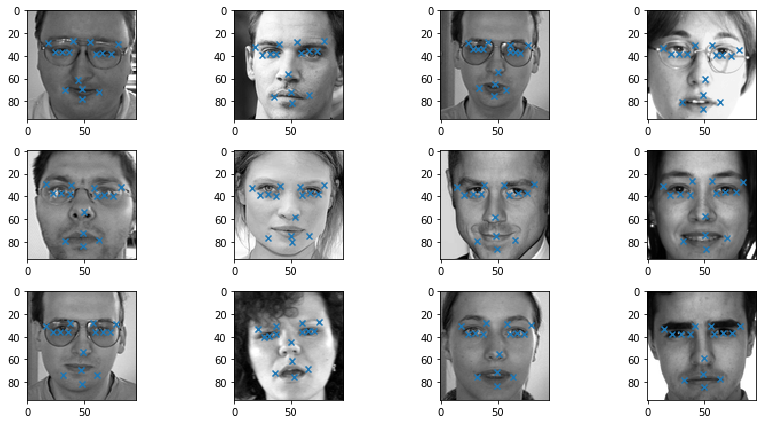

In [14]:
def keypoint_predict(x):
    img = array_to_img(x)
    features = (inception_model.predict(img)).flatten()
#     print(features.shape)
#     print(np.array([[features]]).shape)
    return model.predict(features.reshape(1,2048,1))[0]

import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(X_test[i, :, :, 0], cmap="gray")
    p = keypoint_predict(X_test[i])
    plt.scatter(p[range(0, 30, 2)], p[range(1, 30, 2)], marker='x')

plt.tight_layout()
plt.show()

In [15]:
inception_features_array_test = np.zeros([X_test.shape[0],2048])
for i in range(X_test.shape[0]):
    img = array_to_img(X_test[i])
    features = inception_model.predict(img)
    inception_features_array_test[i] = features.flatten()

inception_features_array_test  = np.expand_dims(inception_features_array_test, axis=2)
score, acc = model.evaluate(inception_features_array_test,y_test)
print(score, acc)

321/321 [==============================] - 1s 2ms/step
8.186696328849436 0.7102803738317757
